In [1]:
import os
import numpy as np
from PIL import Image
import argparse
import cv2
import scipy.sparse
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt
import imutils
import pandas as pd

import itertools
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF

import time
import random
import math

# for creating validation set
from sklearn.model_selection import train_test_split

# for evaluating the model
from sklearn.metrics import accuracy_score
from tqdm import tqdm

!conda info --env

%matplotlib inline



# conda environments:
#
base                     C:\Users\yongwook\anaconda3
outline               *  C:\Users\yongwook\anaconda3\envs\outline



In [2]:

import sys



def print_overwrite(step, total_step, loss, operation):
    sys.stdout.write('\r')
    if operation == 'train':
        sys.stdout.write("Train Steps: %d/%d  Loss: %.4f " % (step, total_step, loss))   
    else:
        sys.stdout.write("Valid Steps: %d/%d  Loss: %.4f " % (step, total_step, loss))
        
    sys.stdout.flush()

In [3]:
data_dir = "./AutoAlign"
test_dir = "./AutoAlign_test"
# made test images never get into data directory.
weights_path = 'face_landmarks_transfer_'

landmark_regex_string = '29@[2479]|30@[34]' # for 18: '29@[1-9]\d?|30@[1-7]'
landmark_number = 6

photo_postfix = "lat_photo.jpg"
tsv_postfix = "lat_photo.txt"
film_postfix = "lat_film.jpg"
tsv_film_postfix = "lat_film.txt"

# ML Playground (CNN, mostly)

## Creating Dataset
Based on above information, we can create custom dataset. 사실 Dataset만 상속받고 나머지는 알아서 잘 해도 된다 하더라.

- https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
- https://blog.paperspace.com/dataloaders-abstractions-pytorch/
- https://stanford.edu/~shervine/blog/pytorch-how-to-generate-data-parallel
- https://pytorch.org/tutorials/beginner/data_loading_tutorial.html



In [4]:
class CustomDataSet(Dataset):


    def __init__(self, data_dir: str, image_postfix:str, tsv_postfix:str,film_postfix:str, film_tsv_postfix:str, landmark_regex:str, landmark_length:int):
        

        self.photo_img_string = image_postfix
        self.photo_tsv_string = tsv_postfix
        self.data_dir = data_dir
        self.landmark_regex = landmark_regex
        self.landmark_length = landmark_length

        files = os.listdir(self.data_dir)

        self.photo_images = [x for x in files if self.photo_img_string in x]
        self.photo_tsvs = [x for x in files if self.photo_tsv_string in x]
        self.film_images = [x for x in files if film_postfix in x]
        self.film_tsvs = [x for x in files if film_tsv_postfix in x]
        assert(len(self.photo_images) == len(self.photo_tsvs))
        for i in range(len(self.photo_images)):
            x, y = self.photo_images[i], self.photo_tsvs[i]
            assert(os.path.splitext(x)[0] == os.path.splitext(y)[0])

    def __len__(self):
        return len(self.photo_tsvs)

    # load_tsv: load tsv --> return dataframe with name, x, y column.
    def load_tsv(self, name):
        # Loading dataframe
        df = pd.read_csv(os.path.join(self.data_dir, name),  sep='\t')
        df = df.iloc[:99, 0:3]
        
        df.columns = ['name', 'X', 'Y']

        return df


    # load_image: load image --> return plt.Image grayscale.
    def load_image(self, name):
        image = cv2.imread(os.path.join(self.data_dir, name), flags=cv2.IMREAD_GRAYSCALE)
        img = Image.fromarray(image)
        return img

    # bounding_box: df(name, x, y) --> return top, left, height, width in integer
    def bounding_box(self, df):
        center = df[df['name'] == '2']

        cy, bottom, cx, right = center['Y'].values[0], df['Y'].max(), center['X'].values[0], df['X'].max()
        dy, dx = bottom - cy, right - cx
        top, left = cy - dy, cx
        # print((left, top), (right, bottom))
        # creating bounding box
        width, height = (right - left), (bottom - top)
        # rand_size_bias = random.uniform(0.9, 1.1)
        # width, height = width * rand_size_bias, height * rand_size_bias

        return int(top), int(left), int(height), int(width)


    def add_random_bias(self, top, left, height, width, bias=0.01):
        top_bias = int(random.uniform(-height*bias,0))
        left_bias = int(random.uniform(-width*bias,0))
        height_bias = -top_bias + int(random.uniform(0, height*bias))
        width_bias = -left_bias + int(random.uniform(0, width*bias))
        top, left, height, width = top + top_bias, left + left_bias, height + height_bias, width + width_bias
        return top, left, height, width

    def extract_landmarks(self, df, landmark_regex, landmark_length):
        # (gathering only needed landmarks)
        df = df.loc[df['name'].str.contains(landmark_regex, regex=True), :]
        # there are **18** landmarks that is unique and valid among all files
        # should we sort df?
        df = df.sort_values(by=['name'])
        df = df.loc[:, ['X', 'Y']]
        df = df.reset_index(drop=True)

        # ... and landmark
        landmark = df.to_numpy(dtype=np.float32)
        return landmark

    def rotate(self, img, landmark, angle):
        angle = random.uniform(-angle, +angle)

        
        transformation_matrix = torch.tensor([
            [+math.cos(math.radians(angle)), -math.sin(math.radians(angle))], 
            [+math.sin(math.radians(angle)), +math.cos(math.radians(angle))]
        ])

        image = imutils.rotate(np.array(img), angle)

        # landmark = landmark - 0.5
        new_landmarks = np.matmul(landmark, transformation_matrix)
        # new_landmarks = new_landmarks + 0.5
        return Image.fromarray(image), np.array(new_landmarks)

    def crop(self, img, landmark, top, left, height, width):
        # Cropping image...
        img = TF.crop(img, top, left, height, width)
        #oh, ow = np.array(img).shape[0], np.array(img).shape[1]
        landmark = torch.tensor(landmark, dtype=torch.float)
        landmark = landmark - torch.tensor([[left, top]])
        landmark = landmark / torch.tensor([width, height])
        return img, landmark

    def normalize(self, img, landmark, height, width):
        # normalizing the pixel values
        img = TF.to_tensor(img)
        img = TF.normalize(img, [0.6945], [0.33497])


        landmark -= 0.5
        return img, landmark

    def __getitem__(self, index):
        
        img_name = self.photo_images[index]
        tsv_name = self.photo_tsvs[index]
        film_name = self.film_images[index]
        film_tsv_name = self.film_tsvs[index]

        img = self.load_image(img_name)
        df = self.load_tsv(tsv_name)

        film = self.load_image(film_name)
        film_df = self.load_tsv(film_tsv_name)

        top, left, height, width = self.bounding_box(df)
        top, left, height, width = self.add_random_bias(top, left, height, width, 0.02)
        landmark = self.extract_landmarks(df, self.landmark_regex, self.landmark_length)

        # rand_top = int(top) + random.randint(-int(height * 0.1), int(height * 0.1))
        # rand_left = int(left) + random.randint(0, int(width * 0.2))

        img, landmark = self.crop(img, landmark, top, left, height, width)

        # resizing image..
        img = TF.resize(img, (224, 224))
        # packing image
        # use dsplit when RGB to make 224x224x3 --> 3x224x224
        #img = np.dsplit(img, img.shape[-1])

        img, landmark = self.rotate(img, landmark, 5)

        # ================== film===================
        ftop, fleft, fheight, fwidth = self.bounding_box(film_df)
        film_landmark = self.extract_landmarks(film_df, self.landmark_regex, self.landmark_length)

        # rand_top = int(top) + random.randint(-int(height * 0.1), int(height * 0.1))
        # rand_left = int(left) + random.randint(0, int(width * 0.2))

        film, film_landmark = self.crop(film, film_landmark, ftop, fleft, fheight, fwidth)

        # resizing image..
        film = TF.resize(film, (224, 224))
        # packing image
        # use dsplit when RGB to make 224x224x3 --> 3x224x224
        #img = np.dsplit(img, img.shape[-1])

        # ===================Build matrix===================

        
        img, landmark = self.normalize(img, landmark, height, width)
        film, film_landmark = self.normalize(film, film_landmark, fheight, fwidth)
        
        result = torch.tensor(landmark, dtype=torch.float) - film_landmark
        #arr = arr.flatten('F')

        return img, film, result, film_landmark

In [5]:


dataset = CustomDataSet(data_dir, photo_postfix, tsv_postfix,film_postfix,tsv_film_postfix,  landmark_regex = landmark_regex_string, landmark_length = landmark_number)
test_dataset = CustomDataSet(test_dir, photo_postfix, tsv_postfix,film_postfix,tsv_film_postfix, landmark_regex = landmark_regex_string, landmark_length = landmark_number)
# split the dataset into validation and test sets
len_train_set = len(dataset)
len_valid_set = len(test_dataset)

print("The length of Train set is {}".format(len_train_set))
print("The length of Valid set is {}".format(len_valid_set))

# train_dataset , valid_dataset,  = torch.utils.data.random_split(dataset , [len_train_set, len_valid_set])


data_train_loader = DataLoader(dataset, batch_size=64, shuffle=True)
print(len(data_train_loader))

valid_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)

The length of Train set is 454
The length of Valid set is 50
8


In [6]:
# Display image and label.
imgs, films, results, film_landmarks = next(iter(data_train_loader))
print(f"Feature batch shape: {imgs.size()}")
print(f"Labels batch shape: {results.size()}")
img = imgs[0]
film = films[0]
result = results[0]
film_landmark = film_landmarks[0]

print((result + film_landmark + 1) * 224 )
# print(f"Label: {label}")
# landmarks = (result) + torch.tensor([0, ])
# print(f"landmarks: {landmarks}")
# plt.figure(figsize=(10, 10))
# plt.imshow(img.squeeze(), cmap='gray')
# plt.scatter(landmarks[:,0], landmarks[:,1], s=8)


Feature batch shape: torch.Size([64, 1, 224, 224])
Labels batch shape: torch.Size([64, 6, 2])
tensor([[289.3795, 206.7234],
        [335.4841, 241.3831],
        [313.4227, 255.7601],
        [327.4757, 265.2539],
        [318.8835, 287.2062],
        [295.7964, 298.3895]])


In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


## Network
Based on https://colab.research.google.com/drive/1-28T5nIAevrDo6MwN0Qi_Cgdy9TEiSP_?usp=sharing#scrollTo=XH_bqPXo6YG8

Resnext50을 이용한다. 일단은 Greyscale(컬러로 확장도 가능하나 실익이 크지 않다.)

https://towardsdatascience.com/face-landmarks-detection-with-pytorch-4b4852f5e9c4

In [8]:
class Network(nn.Module):
    def __init__(self,num_classes=12):
        super().__init__()
        self.model_name='resnet50'
        #self.model=models.resnet18(pretrained=True)
        
        self.model=models.resnet50()


        self.model.conv1=nn.Conv2d(2, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # for param in self.parameters():
        #     param.requires_grad = False

        # RGB:        self.model.conv1=nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        #self.model.conv1=nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
        #self.model.conv1=nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # self.model.fc=nn.Linear(self.model.fc.in_features, num_classes)

        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)
        
    def forward(self, photo, film):
        concated = torch.cat((photo, film), dim=1)
        x = self.model(concated)
        return x

## Training
그림이 커서 그런지 초반에는 구데기로 나오고, 최소 100 epoch 이상은 해 줘야 할 것 같다.

- https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
- http://incredible.ai/artificial-intelligence/2017/05/13/Transfer-Learning/#%EC%83%88%EB%A1%9C-%ED%9B%88%EB%A0%A8%ED%95%A0-%EB%8D%B0%EC%9D%B4%ED%84%B0%EA%B0%80-%EC%A0%81%EC%9C%BC%EB%A9%B0-original-%EB%8D%B0%EC%9D%B4%ED%84%B0%EC%99%80-%EB%8B%A4%EB%A5%B8-%EA%B2%BD%EC%9A%B0
- https://hanqingguo.github.io/Face_detection


In [9]:
# %%capture cap_out --no-stderr

torch.autograd.set_detect_anomaly(True)
network = Network()
# use load_state_dict to load previously trained model.
# checkpoint = torch.load(f"model/0602_0025_6_100_face_landmarks_transfer__resnet50.tar")
# use pth only
# network.load_state_dict(torch.load(f"model/0525_1926_6_100_face_landmarks_transfer__resnext50.pth"))
# use checkpoint
# network.load_state_dict(checkpoint['network_state_dict'])

network.cuda()
print(network)

criterion = nn.MSELoss()

optimizer = optim.Adam(network.parameters(), lr=0.001)
# Load optimizer too
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

loss_min = np.inf
num_epochs = 100

logger = pd.DataFrame(columns=['train loss', 'valid loss'])

start_time = time.time()
time_str = time.strftime(f"%m%d_%H%M")
for epoch in range(1,num_epochs+1):
    
    loss_train = 0
    loss_valid = 0
    running_loss = 0
    
    network.train()
    for step in range(1,len(data_train_loader)+1):
    
        images, films, matrices, _ = next(iter(data_train_loader))
        
        images = images.cuda()
        films = films.cuda()
        matrices = matrices.view(matrices.size(0),-1).cuda() 
        
        predictions = network(images, films)
        
        optimizer.zero_grad()
        
        loss_train_step = criterion(predictions, matrices)
        
        loss_train_step.backward()
        
        optimizer.step()
        
        loss_train += loss_train_step.item()
        running_loss = loss_train/step
        
        print_overwrite(step, len(data_train_loader), running_loss, 'train')
        
    network.eval() 
    with torch.no_grad():
        
        for step in range(1,len(valid_loader)+1):
            
            images, films, matrices, _ = next(iter(data_train_loader))
            images = images.cuda()
            films = films.cuda()
            matrices = matrices.view(matrices.size(0),-1).cuda() 

            predictions = network(images, films)

            loss_valid_step = criterion(predictions, matrices)

            loss_valid += loss_valid_step.item()
            running_loss = loss_valid/step

            print_overwrite(step, len(valid_loader), running_loss, 'valid')
    
    loss_train /= len(data_train_loader)
    loss_valid /= len(valid_loader)
    
    print('\n--------------------------------------------------')
    print('Epoch: {}  Train Loss: {:.4f}  Valid Loss: {:.4f}'.format(epoch, loss_train, loss_valid))
    print('--------------------------------------------------')
    logger.loc[epoch - 1] = [loss_train, loss_valid]

    if loss_valid < loss_min:
        loss_min = loss_valid
        # torch.save(network.state_dict(), f"model/{time_str}_{landmark_number}_{num_epochs}_{weights_path}_{network.model_name}.pth") 
        torch.save({
            'network_state_dict': network.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, f"model/{time_str}_{landmark_number}_{num_epochs}_{weights_path}_{network.model_name}.tar")
        print("\nMinimum Validation Loss of {:.4f} at epoch {}/{}".format(loss_min, epoch, num_epochs))
        print('Model Saved\n')
    
    # cap_out.show()
     
print('Training Complete')
print("Total Elapsed Time : {} s".format(time.time()-start_time))
logger.to_csv(f'csv/{time_str}_{landmark_number}_{num_epochs}_train_data.csv')
# cap_out.show()
# with open(f'csv/{time_str}_{landmark_number}_{num_epochs}_train_log.txt') as capture_file:
#     capture_file.write(cap_out)

del network 

l Saved

Valid Steps: 7/7  Loss: 0.0097 
--------------------------------------------------
Epoch: 2  Train Loss: 0.0102  Valid Loss: 0.0097
--------------------------------------------------

Minimum Validation Loss of 0.0097 at epoch 2/100
Model Saved

Valid Steps: 7/7  Loss: 0.0125 
--------------------------------------------------
Epoch: 3  Train Loss: 0.0035  Valid Loss: 0.0125
--------------------------------------------------
Valid Steps: 7/7  Loss: 0.0031 
--------------------------------------------------
Epoch: 4  Train Loss: 0.0023  Valid Loss: 0.0031
--------------------------------------------------

Minimum Validation Loss of 0.0031 at epoch 4/100
Model Saved

Valid Steps: 7/7  Loss: 0.0037 
--------------------------------------------------
Epoch: 5  Train Loss: 0.0019  Valid Loss: 0.0037
--------------------------------------------------
Valid Steps: 7/7  Loss: 0.0017 
--------------------------------------------------
Epoch: 6  Train Loss: 0.0016  Valid Loss: 0.0017
-

In [9]:
def pixel_distance(landmark, reference):
    ''' pixel_distance(landmark: np.array[[x, y], ..] 
                        reference: np.array[[x, y]] with true landmark value

        return: average: float average distance,
                each: np.array[distance, ..] with distance of each landmark
    '''
    each = []
    for i in range(len(landmark)):
        each.append(np.linalg.norm(landmark[i] - reference[i]))

    each = np.array(each)
    average = np.average(each)

    return average, each


[[113.90863  109.664276]
 [111.752365 109.56361 ]
 [113.03326  109.843185]
 [113.54901  110.03812 ]
 [112.91348  108.8674  ]
 [114.378815 106.09577 ]]
[[107.585464 105.24171 ]
 [111.08393  104.48129 ]
 [113.008675 105.58223 ]
 [113.76787  105.31688 ]
 [115.98806  105.66725 ]
 [117.96434  106.59343 ]]
4.981237
[7.7163167 5.126082  4.261027  4.7263074 4.4377904 3.6198974]
[[117.59544  104.65126 ]
 [116.25199  102.536316]
 [117.9016   103.602936]
 [118.62022  102.46358 ]
 [118.47713  102.22504 ]
 [118.790085 100.925385]]
[[121.867195 114.80204 ]
 [117.02904  112.51307 ]
 [115.230354 111.61699 ]
 [113.07937  110.58859 ]
 [110.62925  109.39437 ]
 [109.29947  108.73213 ]]
10.370079
[11.013001 10.006968  8.447522  9.834474 10.629607 12.288901]
[[104.31901  110.52176 ]
 [104.74749  112.8149  ]
 [109.0431   113.1776  ]
 [110.29514  113.938   ]
 [110.30908  112.54643 ]
 [111.765945 110.55227 ]]
[[113.67937  122.4671  ]
 [107.789345 122.724785]
 [105.39257  120.13335 ]
 [103.26463  120.203354]
 [

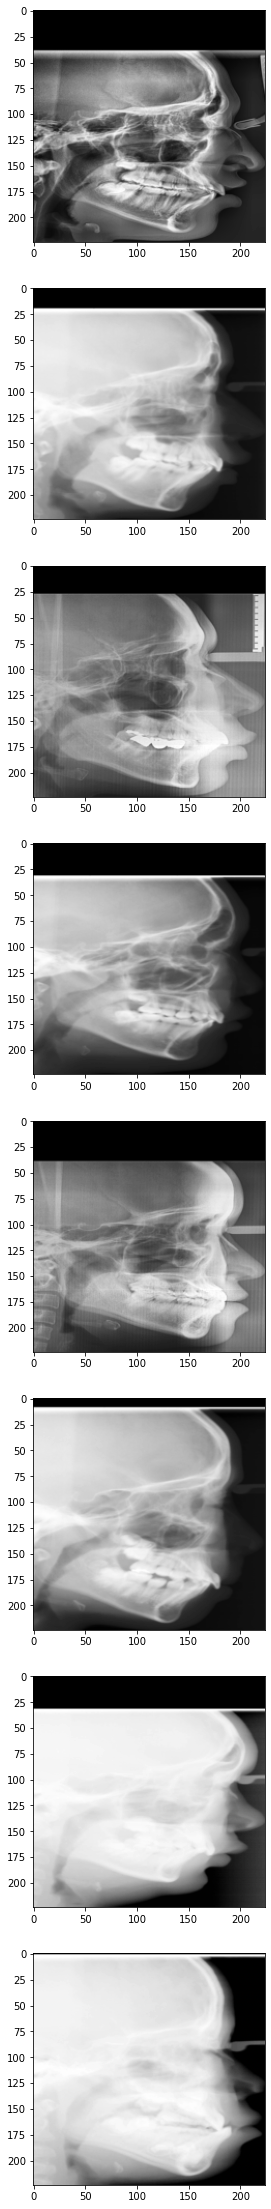

In [10]:
start_time = time.time()

with torch.no_grad():

    best_network = Network()
    best_network.cuda()
    best_network.load_state_dict(torch.load(r"model\0609_0956_6_100_face_landmarks_transfer__resnet50.tar")['network_state_dict'])
    best_network.eval()
    images, films, targets, film_landmarks = next(iter(valid_loader))
    images = images.cuda()
    films = films.cuda()
    targets = (targets+0.5)*224

    predictions = best_network(images, films).cpu()
    predictions = predictions.view(-1,6,2)
    predictions = (predictions+0.5) * 224
    film_landmarks = (film_landmarks+0.5) * 224
    


    
    plt.figure(figsize=(10,40))
    
    for img_num in range(8):
        plt.subplot(8,1,img_num+1)
        film = films[img_num].cpu().numpy().transpose(1,2,0).squeeze()
        plt.imshow(film, cmap='gray')
        film_image = films[img_num].cpu().numpy().transpose(1,2,0).squeeze()
        photo_image = images[img_num].cpu().numpy().transpose(1,2,0).squeeze()

        prediction = predictions[img_num].numpy()
        film_landmark = film_landmarks[img_num].numpy()
        target = targets[img_num].numpy()
        print(prediction)
        print(target)
        matrix, inliers = cv2.estimateAffinePartial2D(film_landmark, film_landmark + prediction, method=cv2.LMEDS)

        warped_image = cv2.warpAffine(film_image, matrix, (photo_image.shape[1], photo_image.shape[0]))
        # plt.imshow(imutils.opencv2matplotlib( warped_image), cmap='gray', alpha=0.5)                
        average, each = pixel_distance(prediction, target)
        # plt.text(0, 224, average)
        # plt.texttarget24, each)
        print(average)
        print(each)
        # plt.show()


print('Total number of test images: {}'.format(len(test_dataset)))

end_time = time.time()
print("Elapsed Time : {}".format(end_time - start_time)) 

## From Face detection to landmark detection, IRL

https://github.com/timesler/facenet-pytorch

- With pip:
pip install facenet-pytorch

- or clone this repo, removing the '-' to allow python imports:
git clone https://github.com/timesler/facenet-pytorch.git facenet_pytorch

- or use a docker container (see https://github.com/timesler/docker-jupyter-dl-gpu):
docker run -it --rm timesler/jupyter-dl-gpu pip install facenet-pytorch && ipython

In [11]:
#######################################################################
common_path = r'AutoAlign_test\B25776___________000_lat'
pi, pt, fi, ft = "_photo.jpg", "_photo.txt", "_film.jpg", "_film.txt"
image_path = common_path + pi
tsv_path = common_path + pt
film_path = common_path + ft
film_img_path = common_path + fi
#######################################################################

In [12]:
def load_tsv(path):
    # Loading dataframe
    df = pd.read_csv(path,  sep='\t')
    df = df.iloc[:99, 0:3]
    
    df.columns = ['name', 'X', 'Y']

    return df

def extract_landmarks(df, landmark_regex, landmark_length):
    # (gathering only needed landmarks)
    df = df.loc[df['name'].str.contains(landmark_regex, regex=True), :]
    # there are **18** landmarks that is unique and valid among all files
    # should we sort df?
    df = df.sort_values(by=['name'])
    df = df.loc[:, ['X', 'Y']]
    df = df.reset_index(drop=True)

    # ... and landmark
    landmark = df.to_numpy(dtype=np.float32)
    return landmark
def load_image(path):
    img = Image.open(path)
    return img


# bounding_box: df(name, x, y) --> return top, left, height, width in integer
def bounding_box(df):
    center = df[df['name'] == '2']

    cy, bottom, cx, right = center['Y'].values[0], df['Y'].max(), center['X'].values[0], df['X'].max()
    dy, dx = bottom - cy, right - cx
    top, left = cy - dy, cx
    # print((left, top), (right, bottom))
    # creating bounding box
    width, height = (right - left), (bottom - top)
    # rand_size_bias = random.uniform(0.9, 1.1)
    # width, height = width * rand_size_bias, height * rand_size_bias

    return int(top), int(left), int(height), int(width)



In [13]:
from facenet_pytorch import MTCNN, InceptionResnetV1

start = time.time()
df = load_tsv(tsv_path)
correct_landmarks = extract_landmarks(df, '29@[2479]|30@[34]', 6)
df2 = load_tsv(film_path)
bbox = bounding_box(df2)
film_landmarks = extract_landmarks(df2, '29@[2479]|30@[34]', 6)

film_image_pil = load_image(film_img_path)
film_image_pil_crop = TF.resized_crop(film_image_pil.convert('L'), bbox[0], bbox[1], bbox[2], bbox[3], size=(224, 224))


film_image = cv2.imread(film_img_path)
# If required, create a face detection pipeline using MTCNN:
mtcnn = MTCNN(image_size=224, device=device)


best_network = Network()
# best_network.load_state_dict(torch.load(f"model/{time_str}_{landmark_number}_{num_epochs}_{weights_path}_{best_network.model_name}.tar")['network_state_dict'])
best_network.load_state_dict(torch.load(r"model\0609_0956_6_100_face_landmarks_transfer__resnet50.tar")['network_state_dict'])
best_network.eval()


image_open = time.time()
input_image = Image.open(image_path)
grayscale_image = input_image.convert('L')
height, width = input_image.size[0], input_image.size[1]
print(height, width)
# Get cropped and prewhitened image tensor
boxes, probs = mtcnn.detect(input_image)
face = boxes[0]
x0, y0, x1, y1 = face
face_width = x1 - x0
x0, y0, x1, y1 = int(x0)+face_width * 0.05, int(y0), int(x1)+face_width * 0.05, int(y1) 

#face = (faces + 1) * 255

# image = np.array(grayscale_image)
# image = image[y0:y1, x0:x1]
# image = TF.crop(grayscale_image, y0, x0, y1-y0, x1-x0)
image = TF.resized_crop(grayscale_image, y0, x0, y1-y0, x1-x0, size=(224, 224))
# plt.imshow(image, cmap='gray')
# plt.imsave("profile_cut.png", image, cmap='gray')
# image = TF.resize(Image.fromarray(image), size=(224, 224))
image = TF.to_tensor(image)
image = TF.normalize(image, [0.6945], [0.33497])

film_image_pil_crop = TF.to_tensor(film_image_pil_crop)
film_image_pil_crop = TF.normalize(film_image_pil_crop, [0.6945], [0.33497])

from_image_inference = time.time()
with torch.no_grad():
   landmarks = best_network(image.unsqueeze(0), film_image_pil_crop.unsqueeze(0))

print(landmarks)
norm_flim_landmarks = (film_landmarks - np.array((bbox[0], bbox[1]))) / np.array((bbox[2], bbox[3])) - 0.5
print(norm_flim_landmarks)
landmarks =  (norm_flim_landmarks + landmarks.view(landmark_number,2).detach().numpy() +1) * np.array([[x1-x0, y1-y0]]) + np.array([[x0, y0]])
print(landmarks)
print(film_landmarks - np.array((bbox[0], bbox[1])))

# plt.figure()
# plt.imshow(input_image)
# plt.scatter(landmarks[:,0], landmarks[:,1], c = 'c', s = 5)
# plt.savefig('result.png', dpi=300)
# plt.show()

end = time.time()
print(f"took about {end - start}s")
print(f"from image open, took {end - image_open}s")
print(f"from inference, took {end - from_image_inference}s")

2992 2000
tensor([[-0.0191, -0.0482, -0.0015, -0.0438,  0.0137, -0.0481,  0.0157, -0.0365,
          0.0304, -0.0434,  0.0286, -0.0394]])
[[ 0.22255489 -0.13663075]
 [ 0.28093812  0.17580803]
 [ 0.22255489  0.31194907]
 [ 0.249002    0.43143976]
 [ 0.24800399  0.51469148]
 [ 0.20758483  0.6136141 ]]
[[2025.39714147 1401.44562965]
 [2071.94929977 1731.55196097]
 [2045.49073113 1868.92554224]
 [2062.93452589 2005.53129594]
 [2071.32338893 2085.06673847]
 [2045.42697042 2192.28744962]]
[[1448.  371.]
 [1565.  690.]
 [1448.  829.]
 [1501.  951.]
 [1499. 1036.]
 [1418. 1137.]]
took about 1.5133683681488037s
from image open, took 0.5143980979919434s
from inference, took 0.20699238777160645s


In [14]:


print(landmarks)
print(correct_landmarks)
print(pixel_distance(landmarks, correct_landmarks))

[[2025.39714147 1401.44562965]
 [2071.94929977 1731.55196097]
 [2045.49073113 1868.92554224]
 [2062.93452589 2005.53129594]
 [2071.32338893 2085.06673847]
 [2045.42697042 2192.28744962]]
[[1835.85    935.9399]
 [1904.274  1124.829 ]
 [1834.766  1206.738 ]
 [1865.815  1278.997 ]
 [1864.432  1329.25  ]
 [1816.3    1388.776 ]]
(699.8258036060165, array([502.61688263, 629.46625514, 694.9080572 , 752.8002982 ,
       783.62171112, 835.54161734]))


In [16]:

matrix, inliers = cv2.estimateAffinePartial2D(film_landmarks[:], landmarks[:], method=cv2.LMEDS)
# matrix, inliers = cv2.estimateAffinePartial2D(film_landmarks, correct_landmarks, method=cv2.LMEDS)
print(matrix)
print(inliers)

translation_x, translation_y = matrix[0, 2], matrix[1, 2]
scale = (matrix[0, 0] * matrix[0, 0] + matrix[1, 0] * matrix[1, 0]) ** 0.5
rotation = np.arctan2(matrix[0, 1], matrix[1, 1])
degree = np.rad2deg(rotation)
print([translation_x, translation_y, scale, degree])
# solution: [-764.8932178875267, -713.3610459581183, 1.9335031260399236, -0.6305061269798841]

output_string = f"translation_x={translation_x}\ntranslation_y={translation_y}\nscale={scale}\ndegree={degree}\n"
with open("output.txt", "w") as output:
    output.write(output_string)

# plt.figure()
# plt.imshow(input_image)
# plt.scatter(landmarks[:,0], landmarks[:,1], c = 'c', s = 5)
# plt.scatter(correct_landmarks[:,0], correct_landmarks[:,1], c = 'r', s = 5)
# plt.savefig('result.png', dpi=300)
# plt.show()

[[ 1.00545201e+00  5.67345054e-02  7.06387996e+02]
 [-5.67345054e-02  1.00545201e+00  7.73006204e+02]]
[[1]
 [1]
 [1]
 [1]
 [1]
 [1]]
[706.387995601134, 773.0062035935111, 1.0070514159061428, 3.2295964733451807]


In [17]:
# load_image: load image --> return opencv.

# input_image_cv2 = np.array(input_image)
# warped_image = cv2.warpAffine(input_image_cv2, matrix, (film_image.shape[1], film_image.shape[0]))
# plt.figure()
# plt.imshow(film_image)
# plt.imshow(warped_image, alpha=0.5)
# plt.show()